In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
import time

In [2]:
cifar_train = datasets.CIFAR10('./', download=True, train=True)
cifar_test = datasets.CIFAR10('./', download=True, train=False)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [3]:
X_train, y_train = torch.FloatTensor(cifar_train.data), torch.LongTensor(cifar_train.targets)
X_test, y_test = torch.FloatTensor(cifar_test.data), torch.LongTensor(cifar_test.targets)


In [4]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [5]:
X_train /= 255.
X_test /= 255.

ship


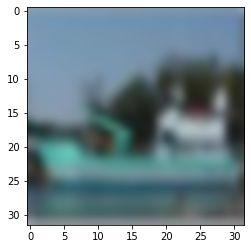

In [7]:
plt.imshow(X_train[111], interpolation='bicubic')
print(cifar_train.classes[y_train[111]])

In [8]:
X_train = X_train.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)

In [9]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [10]:
class LeNet3(nn.Module):
  def __init__(self, 
               activation = 'tanh', 
               pooling = 'avg',
               conv_size=5,
               batch_norm=False):
    super(LeNet3, self).__init__()

    self.activation = activation
    self.pooling = pooling
    self.conv_size = conv_size
    self.batch_norm = batch_norm

    if activation == 'tanh':
      act_f = nn.Tanh()
    elif activation == 'relu':
      act_f = nn.ReLU()
    else:
      raise NotImplementedError

    if pooling == 'avg':
      pool_layer = nn.AvgPool2d(kernel_size=2, stride=2)
    elif pooling =='max':
      pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
    else:
      raise NotImplementedError

    #input = (размер батча,3,32,32) изменилась размерность входного тензора
    if conv_size == 5:
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0) 
      
    elif conv_size==3:
      self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
      self.conv1_2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=0)
    else:
      raise NotImplementedError
    #(размер батча,6,28,28)
    self.act1 = act_f
    self.bn1 = nn.BatchNorm2d(num_features=6)
    self.pool1 = pool_layer
    
    #(размер батча,6,14,14)
    if conv_size == 5:
      self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
    elif conv_size==3:
      self.conv2_1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
      self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
    else:
      raise NotImplementedError
    #(размер батча,16,10,10)

    self.act2 = act_f
    self.bn2 = nn.BatchNorm2d(num_features=16)
    self.pool2 = pool_layer
    #(размер батча,16,5,5)


    # #(размер батча,120,1,1)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120, bias=True)
    self.act3 = act_f
    self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
    self.act4=act_f
    #(размер батча,84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    if self.conv_size==5:
      x = self.conv1(x)
    elif self.conv_size==3:
      x = self.conv1_2(self.conv1_1(x))
    x = self.act1(x) 
    if self.batch_norm:
      x = self.bn1(x)
    x = self.pool1(x)
    
    if self.conv_size==5:
      x = self.conv2(x)
    elif self.conv_size==3:
      x = self.conv2_2(self.conv2_1(x))
    x = self.act2(x) 
    if self.batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)

    return self.fc3(x)


In [11]:
LeNet3().forward(X_train[:10]).shape

torch.Size([10, 10])

In [13]:
def train_nn(net, dataloader, X_test, y_test, epochs=40):
  
  start_time = time.perf_counter()
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=net.parameters())

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  test_loss = []
  test_accuracy = []

  for epoch in range(epochs):
    for train_batch, train_label in dataloader:
      optimizer.zero_grad()
      net.train()
      train_batch, train_label = train_batch.to(device), train_label.to(device)

      preds = net.forward(train_batch)
      loss = criterion(preds, train_label)
      loss.backward()
      optimizer.step()

    net.eval()
    test_preds = net.forward(X_test)
    t_loss = criterion(test_preds, y_test)
    t_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()

    test_loss.append(t_loss.data.cpu())
    test_accuracy.append(t_accuracy.data.cpu())

    if epoch % 5 ==0:
      print(f'Epoch: {epoch}, accuracy: {t_accuracy}')
      print('***')


  del net
  end_time = time.perf_counter()
  print(f'Выполнено за {(end_time-start_time)// 60} минут {(end_time-start_time) % 60 } секунд')
  return  test_accuracy, test_loss





In [14]:
partition = {'train':[]}
labels = {}

for idx, p in enumerate(X_train):

  partition['train'].append(idx)
  labels[idx] = y_train[idx]

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
    self.list_IDs = list_IDs
    self.labels = labels

  def __len__(self):
    return len(self.list_IDs)

  def __getitem__(self, idx):
    ID = self.list_IDs[idx]
    
    X = X_train[ID] #загружаем данные - в другом варианте мы могли бы загружать их с диска
    y = self.labels[ID]
    
    return X, y


params = {'batch_size':100,
          'shuffle':True, 
          'num_workers':4}

train_iter = torch.utils.data.DataLoader(MyDataset(partition['train'], labels), **params)

In [15]:
accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train_nn(LeNet3(activation='tanh', conv_size=5),
          train_iter, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train_nn(LeNet3(activation='relu', conv_size=5),
          train_iter, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train_nn(LeNet3(activation='relu', conv_size=3),
          train_iter, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train_nn(LeNet3(activation='relu', conv_size=3, pooling='max'), 
          train_iter, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train_nn(LeNet3(activation='relu', conv_size=3, pooling='max', batch_norm=True), 
          train_iter, X_test, y_test)

Epoch: 0, accuracy: 0.38659998774528503
***
Epoch: 5, accuracy: 0.5271999835968018
***
Epoch: 10, accuracy: 0.5526000261306763
***
Epoch: 15, accuracy: 0.557200014591217
***
Epoch: 20, accuracy: 0.5547999739646912
***
Epoch: 25, accuracy: 0.5534999966621399
***
Epoch: 30, accuracy: 0.5540000200271606
***
Epoch: 35, accuracy: 0.5475999712944031
***
Выполнено за 12.0 минут 9.177911676999997 секунд
Epoch: 0, accuracy: 0.4147000014781952
***
Epoch: 5, accuracy: 0.526199996471405
***
Epoch: 10, accuracy: 0.5626000165939331
***
Epoch: 15, accuracy: 0.5960000157356262
***
Epoch: 20, accuracy: 0.5909000039100647
***
Epoch: 25, accuracy: 0.6011999845504761
***
Epoch: 30, accuracy: 0.6039999723434448
***
Epoch: 35, accuracy: 0.6003000140190125
***
Выполнено за 11.0 минут 18.349586383999963 секунд
Epoch: 0, accuracy: 0.40700000524520874
***
Epoch: 5, accuracy: 0.5314000248908997
***
Epoch: 10, accuracy: 0.5728999972343445
***
Epoch: 15, accuracy: 0.5957000255584717
***
Epoch: 20, accuracy: 0.6029

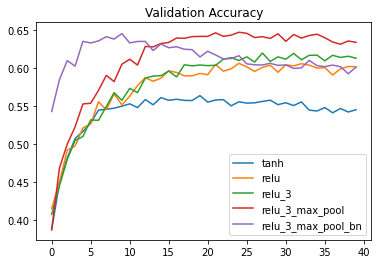

In [16]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

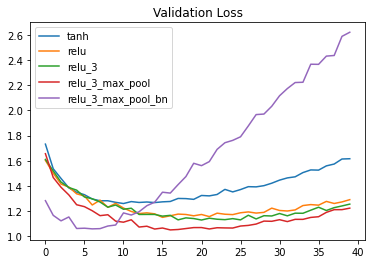

In [17]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');